<a href="https://colab.research.google.com/github/Ehxzel/Open-Ai-Whisper-ASR-for-African-Lang/blob/main/OpenAI_Whisper_(small)_Eval_4_MAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **This is a Python notebook for Testing and Scoring OpenAI Whisper (Small) Model for MotherLand AI MVP, Afri-Roburst.**

This code demonstrates how an audio file can be uploaded, processed, and visually analyzed using AI tools. It loads an audio recording, converts it to a standard format, and then creates two visual representations:

- A waveform that shows how the sound changes over time, and
- A Mel spectrogram that displays the sound’s frequency patterns in color.

These visuals help us understand how speech or sound is structured before it’s analyzed by Whisper for transcription or language understanding. at the last end of the Script, theh WER and CER Scores are added.

## **Installing Dependencies**

In [ ]:
! pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-qipqnt15
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-qipqnt15
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=88e81cf92dd84e8e0d3a1b552ee3c424cfc8d7941d846939676b8765e6d00f9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-80qu8yg2/wheels/c3/03/25/5e0ba78bc27a3a089f137c9f1d92fdfce16d06996c071a016c
Successfully built openai-whisper


In [ ]:
! pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.9 MB/s eta 0:00:00


In [ ]:
!pip install sounddevice soundfile


In [ ]:
!pip install torch


In [ ]:
!pip install torchaudio

In [ ]:
!pip install transformers

## **Script for Uploading Audio File with codec as .wav, .mp3, .flac, .aac...**

In [ ]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from google.colab import files

# 1.Upload your audio file
print("Please upload your audio file (e.g., .wav, .mp3, .flac)")
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]
print(f"Uploaded: {audio_path}")



Please upload your audio file (e.g., .wav, .mp3, .flac)


## **Loading the Whisper Model and Whisper Processor**

In [ ]:

model_name = "openai/whisper-small"
print("Loading model...")
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.eval()
print("Model loaded successfully!")




Loading model...
Model loaded successfully!


## **Audio File Visualization, Reshaping, Projection**

In [ ]:
# # 3.Define helper to load and resample audio
# def load_audio(file_path):
#     waveform, sample_rate = torchaudio.load(file_path)
#     if sample_rate != 16000:
#         transform = torchaudio.transforms.Resample(sample_rate, 16000)     # Intial code.
#         waveform = transform(waveform)
#     return waveform.squeeze(), 16000
#     print(waveform.shape)
#     print(sample_rate)
#     print("Model resampled successfully!!!")

# load_audio(file_path)
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load and visualize the audio
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample to 16kHz if needed
    if sample_rate != 16000:
        transform = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = transform(waveform)
        sample_rate = 16000

    # Display shape info
    print(f"Waveform shape: {waveform.shape}")
    print(f"Sample rate: {sample_rate} Hz")
    print("Audio loaded and resampled successfully!")

    # Play the audio
    display(Audio(waveform.numpy(), rate=sample_rate))

    # Plot waveform
    plt.figure(figsize=(10, 3))
    plt.plot(waveform.t().numpy())
    plt.title("Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # Compute Mel Spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=1024,
        hop_length=256
    )(waveform)

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(
    10 * torch.log10(mel_spectrogram.squeeze(0) + 1e-10).numpy(),
    aspect='auto',
    origin='lower',
    cmap='magma'
    )
    plt.title("Mel Spectrogram")
    plt.xlabel("Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    return waveform.squeeze(), sample_rate


## **Transcription Function**

In [ ]:
# 4.Define transcription function
def transcribe(audio_path):
    audio, rate = load_audio(audio_path)
    input_features = processor(audio, sampling_rate=rate, return_tensors="pt").input_features

    with torch.no_grad():
        predicted_ids = model.generate(input_features)

    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription.strip()



## **Result** **Section**

Transcribing...
Waveform shape: torch.Size([1, 156410])
Sample rate: 16000 Hz
Audio loaded and resampled successfully!


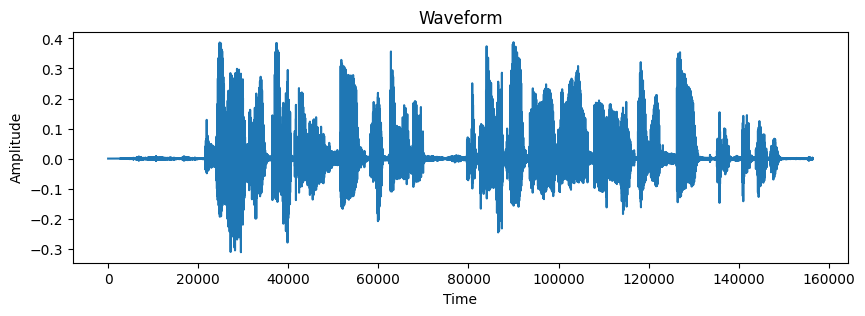

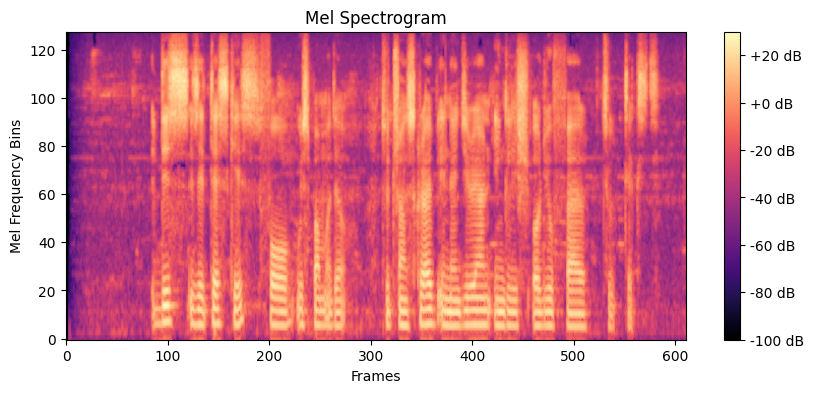


Whisper Transcription:

This is a test case for Whisper model to transcribe in Nigerian English audio file to text.


In [ ]:
# 5.Run transcription
print("Transcribing...")
transcription = transcribe(audio_path)
print("\n=======================")
print("Whisper Transcription:\n")
print(transcription)
print("=======================")

## **Scoring Whisper's Response (WER) with Reference** **Transcript**

In [ ]:
from jiwer import wer, cer
#Compare to reference transcription
reference_text = input("\nEnter the ground truth transcription: ").strip().lower()

#Compute scoring metrics
whisper_lower = transcription.lower()

word_error = wer(reference_text, whisper_lower)
char_error = cer(reference_text, whisper_lower)
accuracy = (1 - word_error) * 100

print("\nWhisper Evaluation Metrics")
print("===============================")
print(f"WER (Word Error Rate):     {word_error:.3f}")
print(f"CER (Character Error Rate): {char_error:.3f}")
print(f"Overall Accuracy:          {accuracy:.2f}%")
print("===============================")


Enter the ground truth transcription: This is a test case for Whisper model to transcribe in Nigerian English audio file to text.

Whisper Evaluation Metrics
WER (Word Error Rate):     0.000
CER (Character Error Rate): 0.000
Overall Accuracy:          100.00%


In [ ]:
import pandas as pd
import os
import random
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from google.colab import files
from jiwer import wer, cer
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from IPython.display import Audio

print("Please log in to your Hugging Face account.")
notebook_login()

# ================================
# Step 1: Choose input source
# ================================
print("Choose input source:")
print("1. Upload your own audio file")
print("2. Load from NaijaVoices dataset")
choice = input("Enter 1 or 2: ").strip()

# ================================
# Step 2: Load audio file
# ================================
if choice == "1":
    print("\nPlease upload your audio file (e.g., .wav, .mp3, .flac)")
    uploaded = files.upload()
    audio_path = list(uploaded.keys())[0]
    print(f"Uploaded: {audio_path}")
    reference_text = input("\nEnter the ground truth transcription (if available): ").strip().lower()
    language = input("\nEnter the spoken language (e.g., 'en', 'yo', 'ig', 'ha', 'pcm'): ").strip()

elif choice == "2":
    # ================================
    # Dynamic NaijaVoices loading
    # ================================
    print("\nLoading from NaijaVoices dataset...")
    dataset_dir = "/content/naijavoices-dataset-compressed"
    metadata_path = os.path.join(dataset_dir, "metadata.csv")

    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at: {metadata_path}")

    # Load metadata
    df = pd.read_csv(metadata_path, sep='~')

    # Show language distribution
    print("\nAvailable languages in dataset:")
    print(df['language'].value_counts())

    # Let user choose which language subset to load
    language = input("\nEnter which language to use (igbo/hausa/yoruba or 'all' for random): ").strip().lower()

    if language in ['igbo', 'hausa', 'yoruba']:
        subset = df[df['language'].str.lower() == language]
    else:
        subset = df  # Random sample from all

    # Pick a random sample
    sample = subset.sample(1).iloc[0]

    # Get metadata
    audio_filename = sample['audio']
    reference_text = sample['text']
    language = sample['language']

    # Build full audio path
    audio_path = os.path.join(dataset_dir, "audio", audio_filename)

    if not os.path.exists(audio_path):
        print(f"⚠️ Warning: Audio file not found at {audio_path}. Check your dataset path.")

    print("\nLoaded sample metadata:")
    print(f"Audio file:   {audio_filename}")
    print(f"Language:     {language}")
    print(f"Speaker ID:   {sample['speaker_id']}")
    print(f"Age Bracket:  {sample['age_bracket']}")
    print(f"Gender:       {sample['gender']}")
    print(f"Transcript:   {reference_text[:100]}...")  # Preview first 100 chars

else:
    raise ValueError("Invalid choice. Please enter 1 or 2.")


  # ================================
# Step 3: Load model
# ================================
model_name = "openai/whisper-small"
print("\nLoading model...")
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.eval()
print("Model loaded successfully!")

# ================================
# Step 4: Audio loading helper
# ================================
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample to 16kHz if needed
    if sample_rate != 16000:
        transform = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = transform(waveform)
        sample_rate = 16000

    print(f"\nWaveform shape: {waveform.shape}")
    print(f"Sample rate: {sample_rate} Hz")

    display(Audio(waveform.numpy(), rate=sample_rate))

    plt.figure(figsize=(10, 3))
    plt.plot(waveform.t().numpy())
    plt.title("Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=1024,
        hop_length=256
    )(waveform)

    plt.figure(figsize=(10, 4))
    plt.imshow(
        10 * torch.log10(mel_spectrogram.squeeze(0) + 1e-10).numpy(),
        aspect='auto',
        origin='lower',
        cmap='magma'
    )
    plt.title("Mel Spectrogram")
    plt.xlabel("Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    return waveform.squeeze(), sample_rate

# ================================
# Step 5: Transcribe audio
# ================================
def transcribe(audio_path, language):
    audio, rate = load_audio(audio_path)
    input_features = processor(audio, sampling_rate=rate, return_tensors="pt").input_features

    # Specify language in forced decoder prompt if given
    forced_decoder_ids = None
    if language:
        forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task="transcribe")

    with torch.no_grad():
        predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)

    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription.strip()

# ================================
# Step 6: Run transcription
# ================================
print("\nTranscribing...")
transcription = transcribe(audio_path, language)
print("\n=======================")
print("Whisper Transcription:\n")
print(transcription)
print("=======================")

# ================================
# Step 7: Evaluate transcription
# ================================
if reference_text:
    whisper_lower = transcription.lower()
    word_error = wer(reference_text, whisper_lower)
    char_error = cer(reference_text, whisper_lower)
    accuracy = (1 - word_error) * 100

    print("\nWhisper Evaluation Metrics")
    print("===============================")
    print(f"WER (Word Error Rate):      {word_error:.3f}")
    print(f"CER (Character Error Rate): {char_error:.3f}")
    print(f"Overall Accuracy:           {accuracy:.2f}%")
    print("===============================")
else:
    print("\nNo reference text provided; skipping evaluation.")


ModuleNotFoundError: No module named 'jiwer'